# Heart Disease Prediction
**Table of Contents**
- [1. Introduction](#1.-Introduction)
- [2. Preprocessing the data](#2.-Preprocessing-the-data)
- [3. Data and Methods](#3.-Data-and-Methods)
- [4. Exploratory Data Analysis (EDA)](#4.-Exploratory-Data-Analysis-(EDA))
    - [4.1. What is the most common chest pain type by age group?](#4.1.-What-is-the-most-common-chest-pain-type-by-age-group?)
    - [4.2. Explore the effect of diabetes on heart disease](#4.2.-Explore-the-effect-of-diabetes-on-heart-disease)
    - [4.3. Explore the effect of hypertension on heart disease](#4.3.-Explore-the-effect-of-hypertension-on-heart-disease)
- [5. Model Building](#5.-Model-Building)
    - [5.1 Feature Engineering](#5.1-Feature-Engineering)
    - [5.2 Model Training](#5.2-Model-Training)

## [1. Introduction](#1.-Introduction)
Heart disease is a significant public health concern, and it remains the leading cause of death worldwide. According to the World Health Organization (WHO), approximately 17.9 million people die each year due to cardiovascular diseases, which accounts for 31% of all global deaths. Thus, early detection of heart disease is essential for better prevention and treatment.

In this project, we aim to develop a data science model that can predict whether a person is likely to have heart disease or not. The dataset we are using contains various attributes such as age, gender, blood pressure, cholesterol level, and other medical history factors.

Using machine learning algorithms and statistical techniques, we will explore the relationships between these variables and develop a model that can accurately predict the likelihood of a person having heart disease. The ultimate goal of this project is to create a reliable and efficient tool that can aid medical professionals in the early detection of heart disease and ultimately reduce the burden of cardiovascular disease on society.

Overall, this project has the potential to make a significant impact on public health by providing a tool that can assist in the early detection and prevention of heart disease.

## [2. Preprocessing the data](#2.-Preprocessing-the-data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import warnings
from typing import Dict, Tuple
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, auc, \
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from skopt import BayesSearchCV

warnings.filterwarnings('ignore')
pd.set_option('display.colheader_justify', 'center')

In [2]:
# Load the data
def load_data(path: str) -> pd.DataFrame:
    return pd.read_csv(path, engine='pyarrow', dtype_backend='pyarrow')


PATH = 'data/heart.csv'
data = load_data(PATH)

In [3]:
# Change the columns name
def changing_columns_name(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns={
        'cp': 'angina',
        'trestbps': 'systolic',
        'chol': 'cholesterol',
        'fbs': 'diabetes',
        'restecg': 'electrocardiogram',
        'thalach': 'max_heart_rate',
        'exang': 'exercise_induced_angina',
        'oldpeak': 'ST_depression',
        'slope': 'ST_slope',
        'ca': 'number_of_major_vessels',
        'thal': 'thalassemia',
        'target': 'heart_disease'
    })

In [4]:
# Change the data types
def changing_data_types(df: pd.DataFrame) -> pd.DataFrame:
    return df.astype({
        'age': 'uint8[pyarrow]',
        'sex': 'bool[pyarrow]',
        'angina': 'uint8[pyarrow]',
        'systolic': 'uint8[pyarrow]',
        'cholesterol': 'uint16[pyarrow]',
        'diabetes': 'bool[pyarrow]',
        'electrocardiogram': 'uint8[pyarrow]',
        'max_heart_rate': 'uint8[pyarrow]',
        'exercise_induced_angina': 'bool[pyarrow]',
        'ST_depression': 'float32[pyarrow]',
        'ST_slope': 'uint8[pyarrow]',
        'number_of_major_vessels': 'uint8[pyarrow]',
        'thalassemia': 'uint8[pyarrow]',
        'heart_disease': 'bool[pyarrow]'
    })

Because the number of major vessels is in range [0, 3], we can remove the outliers.

In [5]:
# Preprocessing the data
def preprocessing_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop_duplicates()

    df = changing_columns_name(df)
    df = changing_data_types(df)

    df = df[df['number_of_major_vessels'].values < 4]

    return df


data = preprocessing_data(data)

## [3. Data and Methods](#3.-Data-and-Methods)
**Information about the dataset**
- "age" - The age of the patient
- "sex" - The gender of the patient
- "angina" - The chest pain experienced (0: Typical Angina, 1: Atypical Angina, 2: Non-Anginal Pain, 3: Asymptomatic)
- "systolic" - The patient's systolic blood pressure (mm Hg on admission to the hospital)
- "cholesterol" - The patient's cholesterol measurement in mg/dl
- "diabetes" - If the patient has diabetes (0: False, 1: True)
- "electrocardiogram" - Resting electrocardiogram results (0: Normal, 1: ST-T Wave Abnormality, 2: Left Ventricular Hypertrophy)
- "max_heart_rate" - The patient's maximum heart rate achieved
- "exercise_induced_angina" - Exercise induced angina (0: No, 1: Yes)
- "ST_depression" - ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)
- "ST_slope" - The slope of the peak exercise ST segment (0: Upsloping, 1: Flatsloping, 2: Downsloping)
- "number_of_major_vessels" - The number of major vessels (0-3)
- "thalassemia" - A blood disorder called thalassemia (0: Normal, 1: Fixed Defect, 2: Reversible Defect)
- "heart_disease" - Heart disease (0: No, 1: Yes)

**Remarks on the dataset**
The dataframe contains 874 rows and 14 columns, with no missing values or duplicate rows. All the numeric columns is positive number. To prevent the loss of important information during analysis, we retained these outliers.

**Methods**
Our exploratory data analysis involved various methodologies, including data cleaning, data visualization, statistical analysis, and machine learning algorithms. To clean the data, we used Pandas to handle missing values, and outliers, and transform variables as necessary. We also used Scikit-learn tools, such as One-Hot-Encoder, to prepare the data for machine learning algorithms. For visualization, we employed Matplotlib and Seaborn to create various plots, including barplots, lineplots, and heat maps, to identify patterns and relationships. Additionally, we utilized the Scipy library for statistical analysis, including the Chi-square test to understand relationships between variables. For machine learning, we implemented various algorithms, such as k-Nearest Neighbors, Logistic Regression, and Random Forests, and evaluated the models based on accuracy, precision, recall, F1 score, and cross-validation. We also used the Scikit-optimize library to optimize the hyperparameters of the models.

In [6]:
data.head()

,age,sex,angina,systolic,cholesterol,diabetes,electrocardiogram,max_heart_rate,exercise_induced_angina,ST_depression,ST_slope,number_of_major_vessels,thalassemia,heart_disease
0,46,True,0,120,249,False,0,144,False,0.8,2,0,3,False
1,71,False,1,160,302,False,1,162,False,0.4,2,2,2,True
2,71,False,1,160,303,False,1,163,False,0.4,2,2,2,True
3,71,False,1,160,304,False,1,164,False,0.4,2,2,2,True
4,71,False,1,160,305,False,1,165,False,0.4,2,2,2,True


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 874 entries, 0 to 885
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   age                      874 non-null    uint8[pyarrow] 
 1   sex                      874 non-null    bool[pyarrow]  
 2   angina                   874 non-null    uint8[pyarrow] 
 3   systolic                 874 non-null    uint8[pyarrow] 
 4   cholesterol              874 non-null    uint16[pyarrow]
 5   diabetes                 874 non-null    bool[pyarrow]  
 6   electrocardiogram        874 non-null    uint8[pyarrow] 
 7   max_heart_rate           874 non-null    uint8[pyarrow] 
 8   exercise_induced_angina  874 non-null    bool[pyarrow]  
 9   ST_depression            874 non-null    float[pyarrow] 
 10  ST_slope                 874 non-null    uint8[pyarrow] 
 11  number_of_major_vessels  874 non-null    uint8[pyarrow] 
 12  thalassemia              87

## [4. Exploratory Data Analysis (EDA)](#4.-Exploratory-Data-Analysis-(EDA))

In [8]:
# Divide age into 6 groups
def divide_age_group(df: pd.DataFrame) -> pd.DataFrame:
    df['age_group'] = pd.cut(df['age'],
                             bins=[28, 37, 45, 53, 61, 69, 77],
                             labels=['29-37', '38-45', '46-53', '54-61', '62-69', '70-77'])
    return df


eda = divide_age_group(data.copy())

In [9]:
# Change the categorical data
def change_categorical_data(df: pd.DataFrame) -> pd.DataFrame:
    df.angina = df.angina.map({
        0: 'TA',
        1: 'ATA',
        2: 'NAP',
        3: 'ASY'
    }).astype('category')
    df.electrocardiogram = df.electrocardiogram.map({
        0: 'N',
        1: 'ST-T',
        2: 'LVH'
    }).astype('category')
    df.ST_slope = df.ST_slope.map({
        0: 'UP',
        1: 'FLAT',
        2: 'DOWN'
    }).astype('category')
    df.thalassemia = df.thalassemia.map({
        0: 'N',
        1: 'FD',
        2: 'RD'
    }).astype('category')

    return df


eda = change_categorical_data(eda)

In [10]:
num = eda.select_dtypes(include='number')
cat = eda.select_dtypes(exclude='number')

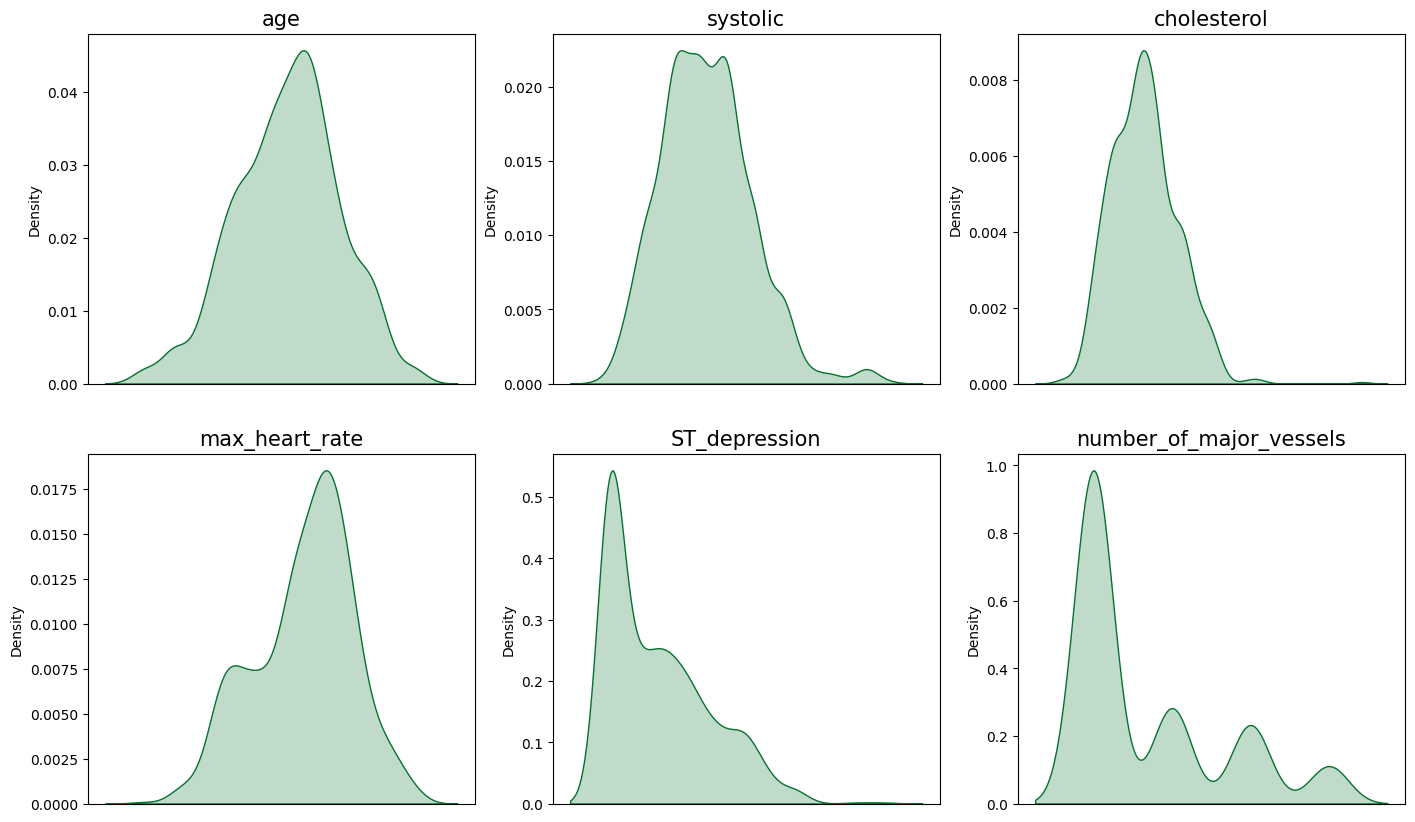

In [11]:
# Plot the distribution of the numerical features
def plot_distribution(df: pd.DataFrame) -> None:
    sns.set_palette('BuGn_r')
    fig, axes = plt.subplots(2, 3, figsize=(17, 10))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.kdeplot(df[col], ax=ax, fill=True)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()


plot_distribution(num)

In [12]:
# Table of basic statistics of the numerical features
def basic_statistics(df: pd.DataFrame):
    return df.describe().T.style.background_gradient(cmap='Paired') \
        .set_properties(**{
        'font-size': '10pt',
        'width': '100px',
        'height': '30px',
        'text-align': 'center'}) \
        .set_caption('Table 1. Basic statistics of the numerical features')


basic_statistics(num)

,count,mean,std,min,25%,50%,75%,max
age,874.000000,54.137300,9.102290,29.000000,48.000000,54.000000,60.000000,77.000000
systolic,874.000000,132.113272,16.918570,94.000000,120.000000,130.000000,140.000000,200.000000
cholesterol,874.000000,247.645309,47.452636,126.000000,211.000000,245.000000,274.000000,564.000000
max_heart_rate,874.000000,149.516018,24.051783,71.000000,133.000000,153.000000,166.000000,206.000000
ST_depression,874.000000,1.096682,1.149999,0.000000,0.000000,0.800000,1.800000,6.200000
number_of_major_vessels,874.000000,0.669336,0.960526,0.000000,0.000000,0.000000,1.000000,3.000000


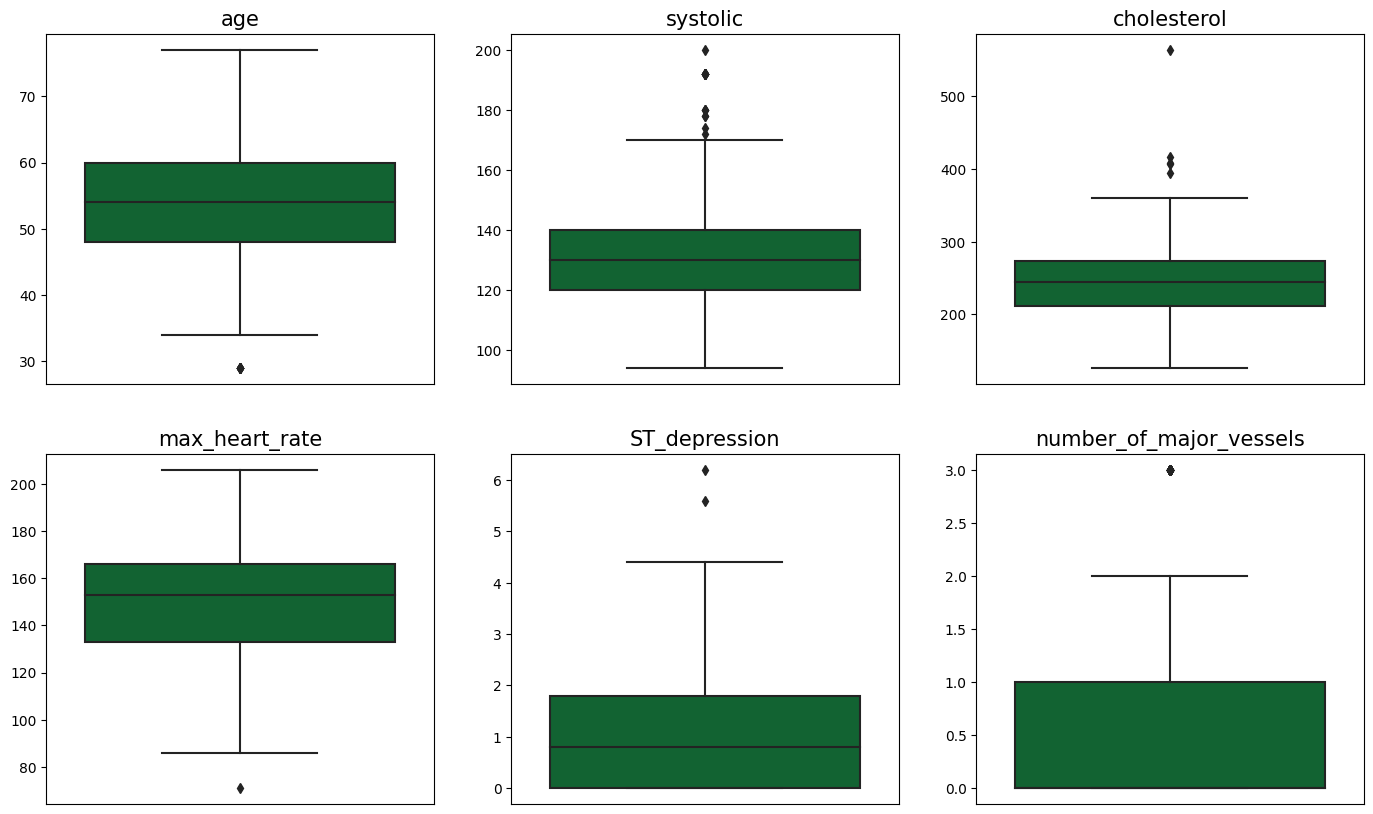

In [13]:
# Plot the statistics of the numerical features
def plot_statistics(df: pd.DataFrame) -> None:
    sns.set_palette('BuGn_r')
    fig, axes = plt.subplots(2, 3, figsize=(17, 10))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.boxplot(df[col], ax=ax)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()


plot_statistics(num)

In [14]:
# Table of the number of outliers
def number_of_outliers(df: pd.DataFrame) -> pd.DataFrame:
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    return ((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).sum() \
        .to_frame('number_of_outliers').style.background_gradient(cmap='Paired') \
        .set_properties(**{
        'font-size': '10pt',
        'width': '100px',
        'height': '30px',
        'text-align': 'center'}) \
        .set_caption('Table 2. Number of outliers')


number_of_outliers(num)

,number_of_outliers
age,9
systolic,17
cholesterol,5
max_heart_rate,1
ST_depression,2
number_of_major_vessels,60


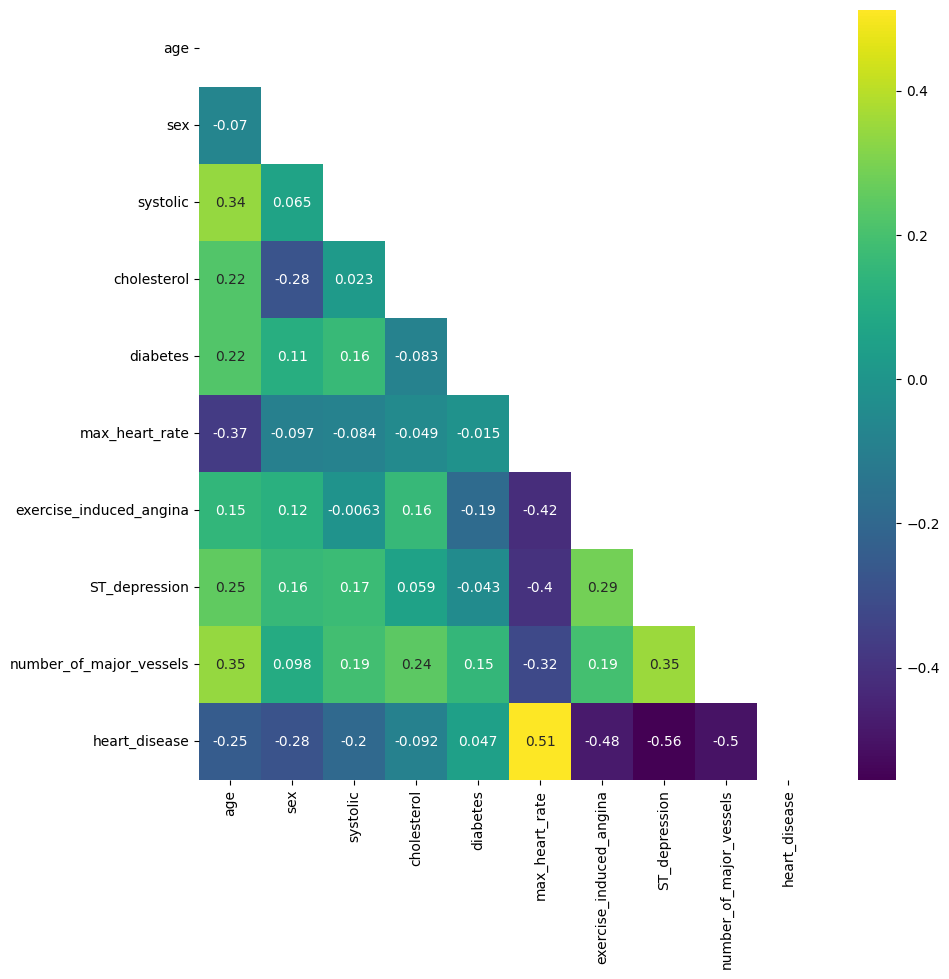

In [15]:
# Plot the correlation between the features
def plot_correlation(df: pd.DataFrame) -> None:
    df = df.astype({
        col: 'uint8[pyarrow]'
        for col in df.select_dtypes(include='bool[pyarrow]').columns
    })
    corr = df.corr()

    fig, ax = plt.subplots(figsize=(10, 10))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(df.corr(), annot=True, ax=ax, cmap='viridis', mask=mask)

    plt.show()


plot_correlation(eda.select_dtypes(exclude='category'))

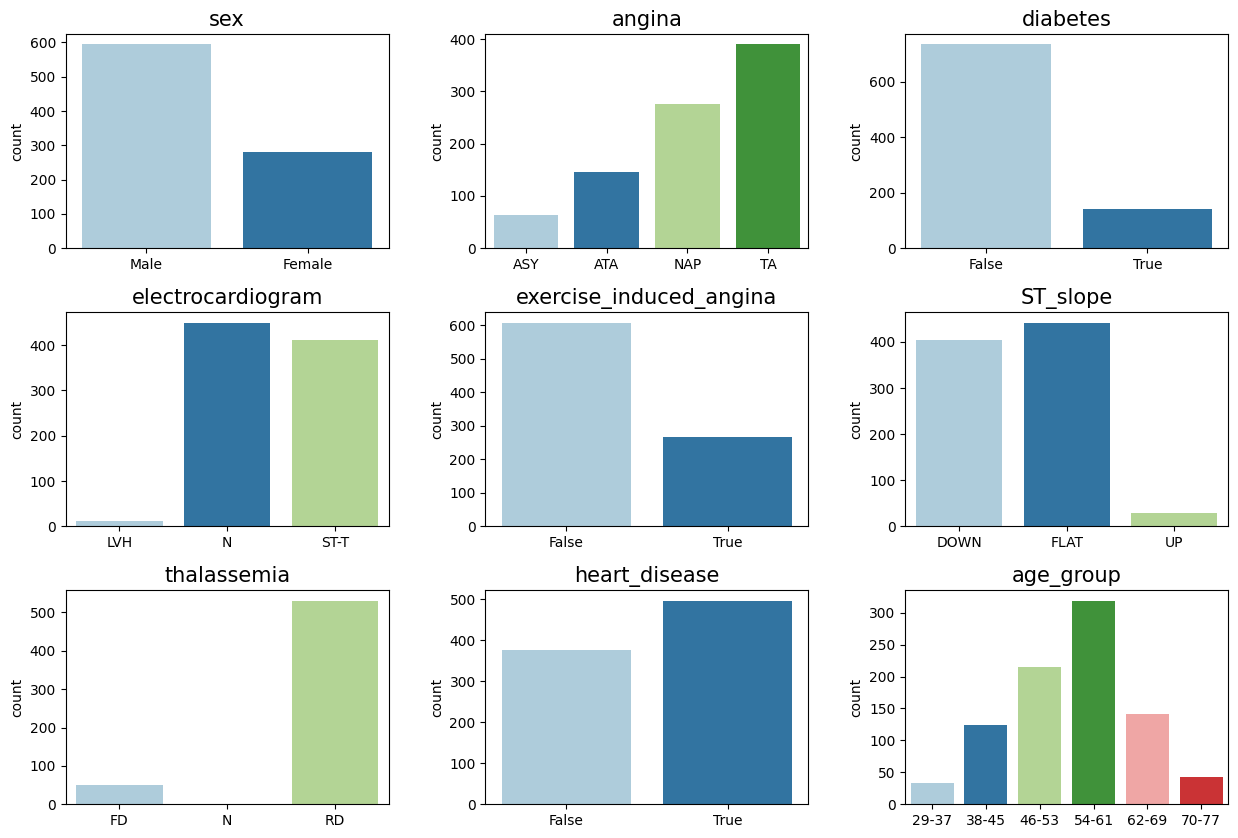

In [16]:
# Plot categorical features
def plot_category(df: pd.DataFrame) -> None:
    df.sex = df.sex.map({True: 'Male', False: 'Female'})

    sns.set_palette('Paired')
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


plot_category(cat.copy())

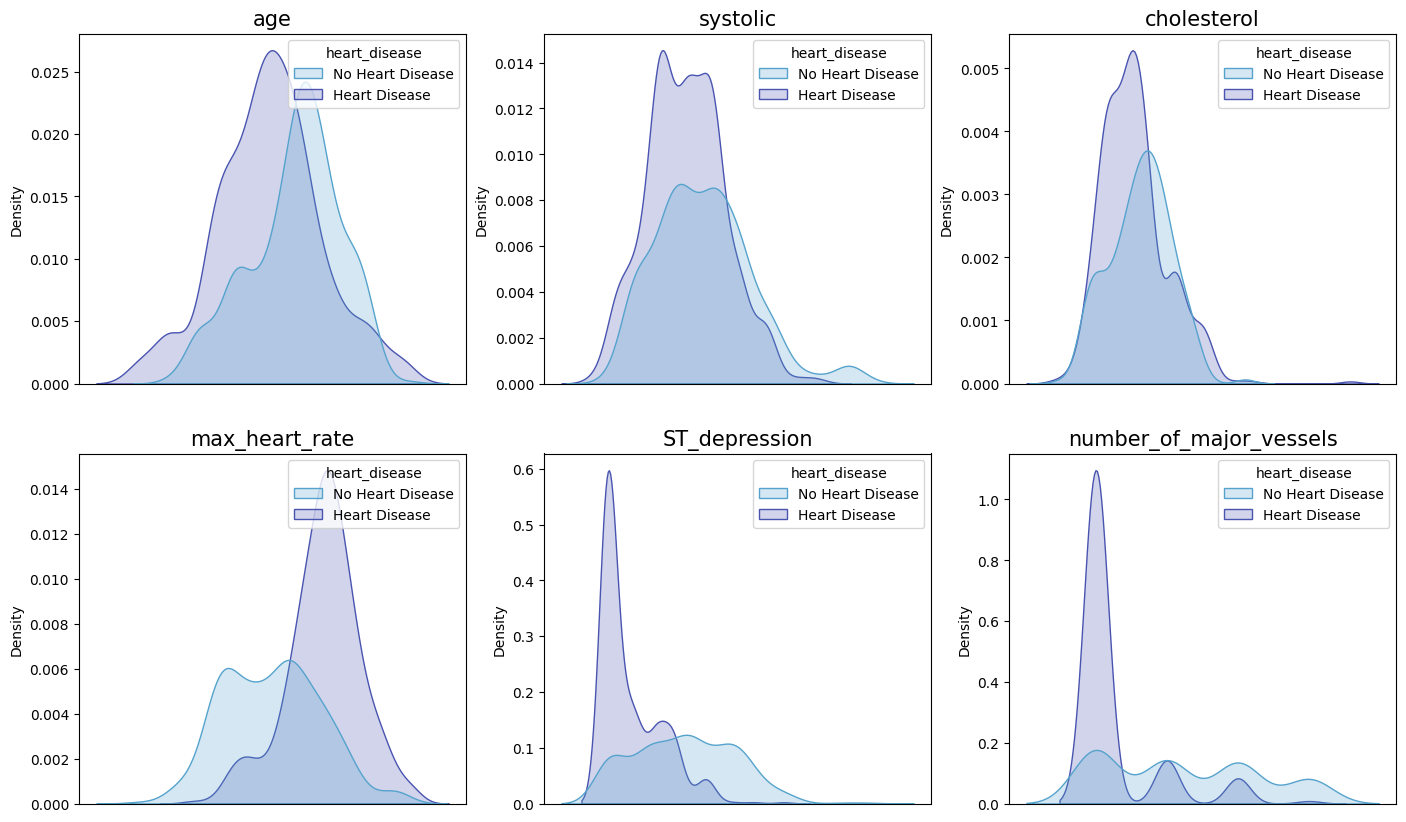

In [17]:
# Plot the distribution of the numerical features by heart disease
def plot_distribution_by_heart_disease(df: pd.DataFrame) -> None:
    df.heart_disease = df.heart_disease.map({True: 'Heart Disease', False: 'No Heart Disease'})

    sns.set_palette('icefire')
    fig, axes = plt.subplots(2, 3, figsize=(17, 10))

    for ax, col in zip(axes.flatten(), df.columns.delete(-1)):
        sns.kdeplot(data=df, x=col, hue='heart_disease', ax=ax, fill=True)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()


plot_distribution_by_heart_disease(pd.concat([num, cat['heart_disease']], axis=1))

### [4.1. What is the most common chest pain type by age group?](#4.1.-What-is-the-most-common-chest-pain-type-by-age-group?)

In [18]:
# Ranking chest pain types table by age group
def ranking_angina_by_age_group(df: pd.DataFrame) -> pd.io.formats.style.Styler:
    df.angina = df.angina.map({
        'TA': 'Typical',
        'ATA': 'Atypical',
        'NAP': 'Non-anginal',
        'ASY': 'Asymptomatic'
    })

    age_group = df.groupby(['age_group', 'angina']).size().reset_index(name='counts')

    pivot_table = pd.pivot_table(age_group,
                                 values='counts',
                                 index='angina',
                                 columns='age_group').rank(ascending=False, axis=0)

    return pivot_table.style.format('{:.0f}').background_gradient(cmap='tab20c') \
        .set_properties(**{'font-size': '10pt',
                           'width': '100px',
                           'height': '50px',
                           'text-align': 'center'}) \
        .set_caption(
        'Table 3. Ranking chest pain types by age group')


ranking_angina_by_age_group(eda.copy())

age_group,29-37,38-45,46-53,54-61,62-69,70-77
angina,,,,,,
Asymptomatic,2,4,4,4,3,4
Atypical,1,3,3,3,4,3
Non-anginal,4,2,1,2,2,1
Typical,3,1,2,1,1,2


According to the table, the blue color indicates the most frequent chest pain type by age group. Based on the data, we can conclude the following:
- *****Typical*** is the most common type of chest pain across all age groups except for 29-37, 46-53, and 70-77 age groups**, where the most common type of chest pain is ***Atypical*** and ***Non-anginal***.
- *****Non-anginal*** is the most second common type of chest pain across all age groups except for 29-37, 46-53, and 70-77 age groups**, where the most second common type of chest pain is ***Asymptomatic*** and ***Typical***.
- *****Atypical*** is the most third common type of chest pain across all age groups except for 29-37 and 62-69 age groups**, where the most third common type of chest pain is ***Typical*** and ***Asymptomatic***.
- *****Asymptomatic*** is the most fourth common type of chest pain across all age groups except for 29-37 and 62-69 age groups**, where the most fourth common type of chest pain is ***Non-anginal*** and ***Atypical***.

We can also visualise the count of chest pain type highlighting in green what has been recognized as the most frequent of the chest pain type.

Figure 1. Count of chest pain type by age group


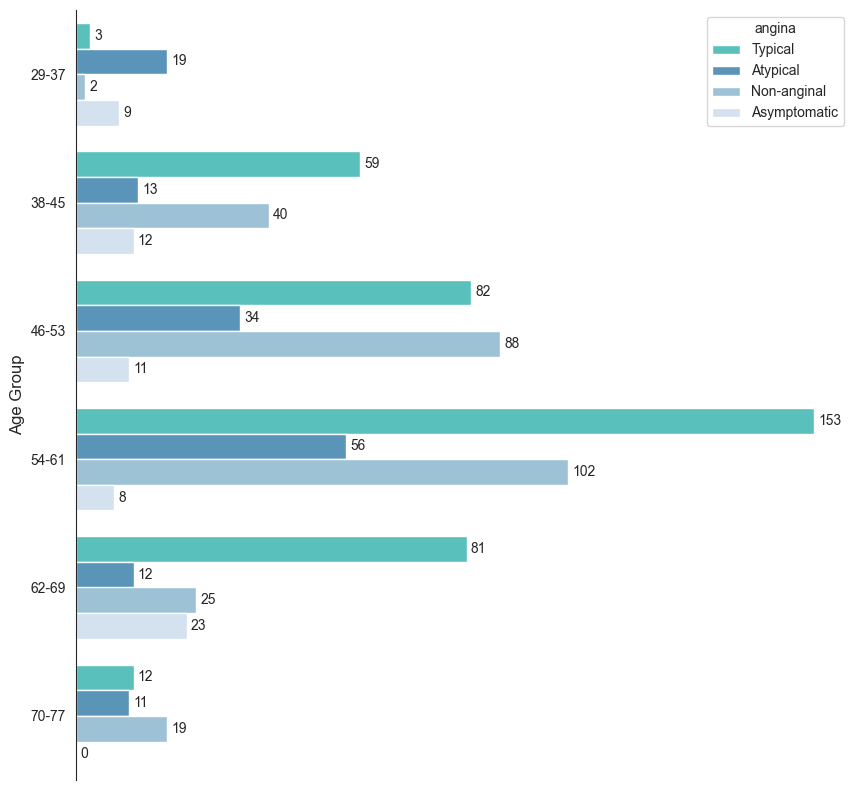

In [19]:
# Count of chest pain type by age group
def count_angina_by_age_group(df: pd.DataFrame) -> None:
    df.angina = df.angina.map({
        'TA': 'Typical',
        'ATA': 'Atypical',
        'NAP': 'Non-anginal',
        'ASY': 'Asymptomatic'
    }).astype('string[pyarrow]')
    unique_angina = df.angina.unique()

    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10, 10))

    blues = sns.color_palette('Blues', n_colors=len(unique_angina))
    custom_palette = ['mediumturquoise' if angina == 'Typical'
                      else blues[len(unique_angina) - 1 - i]
                      for i, angina in enumerate(unique_angina)]
    sns.countplot(data=df,
                  y='age_group',
                  hue='angina',
                  order=df.age_group.sort_values().unique(),
                  palette=custom_palette)

    for bar in ax.patches:
        width = bar.get_width()
        x_ = width
        y_ = bar.get_y() + bar.get_height() / 2
        label = f"{width:.0f}"
        ax.annotate(label, (x_, y_),
                    ha='left', va='center',
                    xytext=(3, 0), fontsize=10,
                    textcoords='offset points')

    sns.despine(bottom=True)
    plt.ylabel('Age Group', fontsize=12)
    plt.xlabel('')
    plt.xticks([])

    plt.show()


print('Figure 1. Count of chest pain type by age group')
count_angina_by_age_group(eda.copy())

### [4.2. Explore the effect of diabetes on heart disease](#4.2.-Explore-the-effect-of-diabetes-on-heart-disease)

Figure 2. The effect of a diabetes diagnosis on heart disease


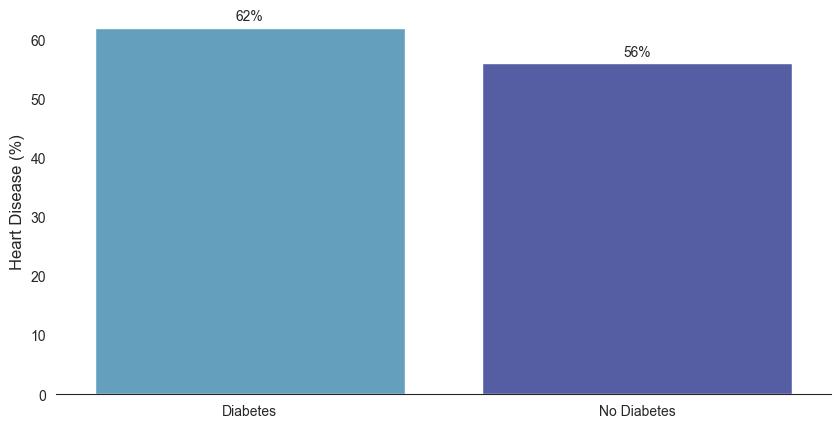

In [20]:
# Plot the effect of a diabetes diagnosis on heart disease
def plot_diabetes_by_heart_disease(df: pd.DataFrame) -> None:
    df.diabetes = df.diabetes.map({True: 'Diabetes', False: 'No Diabetes'})

    disease_rate = df.groupby('diabetes')['heart_disease'] \
        .value_counts(normalize=True) \
        .mul(100).round() \
        .reset_index(name='Heart Disease (%)') \
        .query('heart_disease == True')

    sns.set_palette('icefire')
    fig, ax = plt.subplots(figsize=(10, 5))

    sns.barplot(data=disease_rate,
                x='diabetes',
                y='Heart Disease (%)')

    for bar in ax.patches:
        height = bar.get_height()
        x_ = bar.get_x() + bar.get_width() / 2
        y_ = height
        label = f"{height:.0f}%"
        ax.annotate(label, (x_, y_),
                    ha='center', va='bottom',
                    xytext=(0, 3), fontsize=10,
                    textcoords='offset points')

    sns.despine(left=True)
    plt.ylabel('Heart Disease (%)', fontsize=12)
    plt.xlabel('')

    plt.show()


print('Figure 2. The effect of a diabetes diagnosis on heart disease')
plot_diabetes_by_heart_disease(eda.copy())

From the bar plot above we can conclude that:
- **Diabetes patients have a heart disease rate of 62%.**
- **Patients without diabetes have a 56% heart disease rate.**

It appears that patients diagnosed with diabetes have a higher positive heart disease rate than those without diabetes.
- But are these data reliable?
- Are they significant, or are they the product of randomness?

We decide to perform a chi-square test of independence to verify the reliability of the data
- **Null hypothesis**: There is no association between diabetes and heart disease rate.
- **Alternative hypothesis**: Diabetes and heart disease rate are associated.
- **Threshold**: p-value < 0.05

In [21]:
# Chi-square test of independence
def chi_square_test(df: pd.DataFrame, cols: Tuple[str, str]) -> Tuple[float, float, int, np.ndarray]:
    table = pd.crosstab(df[cols[0]], df[cols[1]])
    return chi2_contingency(table.values)

In [22]:
# Chi-square test for diabetes and heart disease
def diabetes_heart_disease_chi_square_test(df: pd.DataFrame) -> None:
    chi2, p, dof, expected = chi_square_test(df, ('diabetes', 'heart_disease'))
    print(f'Chi-square test of independence: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies: {expected}')
    print(f'p-value < 0.05: {p < 0.05}')
    print(f'Chi-square test of independence > 3.84: {chi2 > 3.84}')


print('Chi-square test for diabetes and heart disease')
diabetes_heart_disease_chi_square_test(eda.copy())

Chi-square test for diabetes and heart disease
Chi-square test of independence: 1.6456097526104223
p-value: 0.19955752208047403
Degrees of freedom: 1
Expected frequencies: [[316.61098398 417.38901602]
 [ 60.38901602  79.61098398]]
p-value < 0.05: False
Chi-square test of independence > 3.84: False


The chi-square test of independence shows that:
- **The chi-square test of independence is less than 3.84.**
- **The p-value is greater than 0.05.**

Therefore, we can conclude that the data is not reliable and the association between diabetes and heart disease rate is not significant.

### [4.3. Explore the effect of hypertension on heart disease](#4.3.-Explore-the-effect-of-hypertension-on-heart-disease)
High blood pressure, also called hypertension, is blood pressure that is higher than normal. Your blood pressure changes throughout the day based on your activities. Having blood pressure measures consistently above normal may result in a diagnosis of high blood pressure (or hypertension).

The higher your blood pressure levels, the more risk you have for other health problems, such as heart disease, heart attack, and stroke.

Your health care team can diagnose high blood pressure and make treatment decisions by reviewing your systolic and diastolic blood pressure levels and comparing them to levels found in certain guidelines.

The guidelines used to diagnose high blood pressure may differ from health care professional to health care professional:

Some health care professionals diagnose patients with high blood pressure if their blood pressure is consistently 140/90 mm Hg or higher.2 This limit is based on a guideline released in 2003 [source](https://www.nhlbi.nih.gov/files/docs/guidelines/express.pdf)
Other health care professionals diagnose patients with high blood pressure if their blood pressure is consistently 130/80 mm Hg or higher.1 This limit is based on a guideline released in 2017 [source](https://www.jacc.org/doi/10.1016/j.jacc.2017.11.006?_ga=2.86879320.1182640551.1528306905-1524800955.1528306905)

We decide to use the 2017 guideline to diagnose hypertension.

In [23]:
eda['hypertension'] = eda.systolic > 130

Figure 3. The effect of a hypertension diagnosis on heart disease


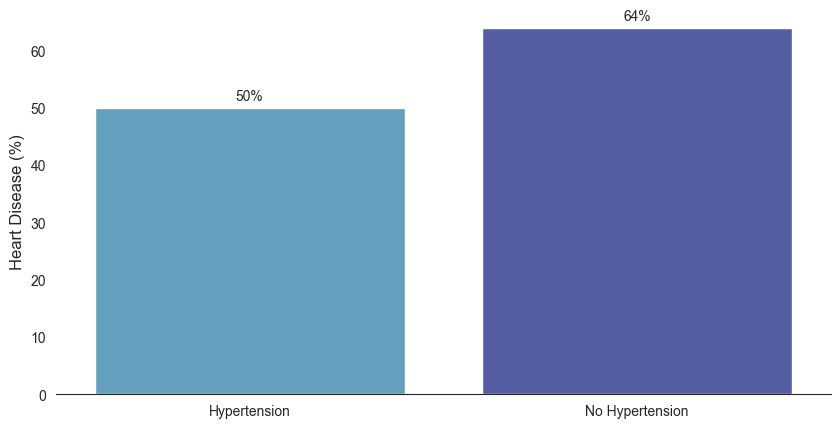

In [24]:
# Plot the effect of a hypertension diagnosis on heart disease
def plot_hypertension_by_heart_disease(df):
    df.hypertension = df.hypertension.map({True: 'Hypertension', False: 'No Hypertension'})

    disease_rate = df.groupby('hypertension')['heart_disease'] \
        .value_counts(normalize=True) \
        .mul(100).round() \
        .reset_index(name='Heart Disease (%)') \
        .query('heart_disease == True')

    sns.set_palette('icefire')
    fig, ax = plt.subplots(figsize=(10, 5))

    sns.barplot(data=disease_rate,
                x='hypertension',
                y='Heart Disease (%)')

    for bar in ax.patches:
        height = bar.get_height()
        x_ = bar.get_x() + bar.get_width() / 2
        y_ = height
        label = f"{height:.0f}%"
        ax.annotate(label, (x_, y_),
                    ha='center', va='bottom',
                    xytext=(0, 3), fontsize=10,
                    textcoords='offset points')

    sns.despine(left=True)
    plt.ylabel('Heart Disease (%)', fontsize=12)
    plt.xlabel('')

    plt.show()


print('Figure 3. The effect of a hypertension diagnosis on heart disease')
plot_hypertension_by_heart_disease(eda.copy())

From the bar plot above we can conclude that:
- **Hypertension patients have a heart disease rate of 62%.**
- **Patients without hypertension have a 56% heart disease rate.**

It appears that patients diagnosed with diabetes have a higher positive heart disease rate than those without diabetes.
- But are these data reliable?
- Are they significant, or are they the product of randomness?

We decide to perform a chi-square test of independence to verify the reliability of the data
- **Null hypothesis**: There is no association between hypertension and heart disease rate.
- **Alternative hypothesis**: Hypertension and heart disease rate are associated.
- **Threshold**: p-value < 0.05

In [25]:
# Chi-square test for hypertension and heart disease
def hypertension_heart_disease_chi_square_test(df: pd.DataFrame) -> None:
    chi2, p, dof, expected = chi_square_test(df, ('hypertension', 'heart_disease'))
    print(f'Chi-square test of independence: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    print(f'Expected frequencies: {expected}')
    print(f'p-value < 0.05: {p < 0.05}')
    print(f'Chi-square test of independence > 3.84: {chi2 > 3.84}')


print('Chi-square test for hypertension and heart disease')
hypertension_heart_disease_chi_square_test(eda.copy())

Chi-square test for hypertension and heart disease
Chi-square test of independence: 16.89694124479942
p-value: 3.9465126770832034e-05
Degrees of freedom: 1
Expected frequencies: [[197.5583524 260.4416476]
 [179.4416476 236.5583524]]
p-value < 0.05: True
Chi-square test of independence > 3.84: True


The chi-square test of independence shows that:
- **The chi-square test of independence is greater than 3.84.**
- **The p-value is less than 0.05.**

Therefore, the null hypothesis is rejected in favor of the alternative hypothesis, then we conclude that:
- **Hypertension effects heart disease rate.**

## [5. Model Building](#5.-Model-Building)
Another possible solution is to use machine learning algorithms to create predictive models based on patient data, to identify the clinical characteristics that most influence the risk of heart disease. Once identify these characteristics, healthcare professionals can focus their monitoring efforts on patients with a higher likelihood of heart disease. Thus, the availability of machine-learning-based predictive tools enables health professionals to take a more targeted and efficient approach to care management for vulnerable patients.

The case of heart disease can be treated as a binary classification problem. The goal is to predict whether a patient will have heart disease. The target variable in this case can be specified as a binary variable, with ```1``` representing the positive class (patient have heart disease) and ```0``` representing the negative class (patient does not have heart disease).

A wide range of machine learning algorithms can be used to solve the problem, we will use:
- Nonlinear classification methods, such as the k-nearest-neighbors method. The K-NeighborsClassifier uses a distance function to determine the k neighbors most similar to the instance to be classified and assigns the instance to the most common class among the neighbors.
- Linear classification techniques, such as LogisticRegression, which use a logistic function to predict the probability that an instance belongs to one of two classes.
- Decision tree algorithms can be used to simulate more complex interactions between input factors and the target variable. RandomForestClassifier is a machine-learning model built from a collection of decision trees, each of which is trained on a different subset of training data. The program averages the predictions of all the trees to provide a final prediction.

To evaluate the performance of machine learning models, we will use various metrics, such as accuracy, precision, recall, and F1 score.
- Accuracy reflects the percentage of correct predictions of the model.
- Precision is the percentage of correct positive predictions made by the model out of all positive predictions made by the model.
- Recall is the percentage of correct positive predictions out of the total true positives in the data set.
- F1 score is the harmonic mean of accuracy and recall.

The ROC-AUC (Area Under the Receiver Operating Characteristic Curve) and PR-AUC (Area Under the Precision Recall Curve) can be used to evaluate the discriminative abilities of the model.

### [5.1 Feature Engineering](#5.1-Feature-Engineering)

In [26]:
ml = eda.drop(['hypertension', 'age_group'], axis=1)
seed = 1

In [27]:
# Split data
def split_data(df: pd.DataFrame, test_size: float, random_state: int) -> Tuple[
    pd.DataFrame, pd.Series, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    x_ = df.drop('heart_disease', axis=1)
    y_ = df['heart_disease']

    x_train_, x_test_, y_train_, y_test_ = train_test_split(x_, y_, test_size=test_size, random_state=random_state)

    return x_, y_, x_train_, x_test_, y_train_, y_test_

In [28]:
# Create pipelines
def create_pipelines(features: pd.DataFrame) -> Dict[str, Pipeline]:
    num_selector = make_column_selector(dtype_include='number')
    cat_selector = make_column_selector(dtype_exclude='number')

    num_cols = num_selector(features)
    cat_cols = cat_selector(features)

    num_preprocessor = StandardScaler()
    cat_preprocessor = OneHotEncoder()

    preprocessor = ColumnTransformer([
        ('StandardScaler', num_preprocessor, num_cols),
        ('OneHotEncoder', cat_preprocessor, cat_cols)
    ])

    return {
        'K-Nearest Neighbors Classifier': make_pipeline(preprocessor, KNeighborsClassifier()),
        'Logistic Regression': make_pipeline(preprocessor, LogisticRegression()),
        'Random Forest Classifier': make_pipeline(preprocessor, RandomForestClassifier())
    }

In [29]:
x, y, x_train, x_test, y_train, y_test = split_data(ml.copy(), 0.2, seed)
pipelines = create_pipelines(x)

### [5.2 Model Training](#5.2-Model-Training)

In [30]:
# Get the model metrics
def metrics_from_pipelines() -> pd.io.formats.style.Styler:
    train_accs = []
    train_f1s = []
    train_roc_aucs = []
    train_pr_aucs = []
    train_precs = []
    train_recs = []
    train_specs = []
    train_fprs_list = []
    train_fnrs_list = []

    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_pr_aucs = []
    test_precs = []
    test_recs = []
    test_specs = []
    test_fprs_list = []
    test_fnrs_list = []

    for name, pipeline in pipelines.items():
        pipeline.fit(x_train, y_train)
        y_pred_test = pipeline.predict(x_test)
        y_pred_train = pipeline.predict(x_train)

        y_probs_test = pipeline.predict_proba(x_test)[:, 1]
        y_probs_train = pipeline.predict_proba(x_train)[:, 1]

        train_precisions, train_recalls, threshold = precision_recall_curve(y_train, y_probs_train)
        test_precisions, test_recalls, threshold = precision_recall_curve(y_test, y_probs_test)

        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

        train_accs.append(accuracy_score(y_train, y_pred_train))
        train_f1s.append(f1_score(y_train, y_pred_train))
        train_roc_aucs.append(roc_auc_score(y_train, y_probs_train))
        train_pr_aucs.append(auc(train_recalls, train_precisions))
        train_precs.append(precision_score(y_train, y_pred_train))
        train_recs.append(recall_score(y_train, y_pred_train))
        train_specs.append(tn_train / (tn_train + fp_train))
        train_fprs_list.append(fp_train / (fp_train + tn_train))
        train_fnrs_list.append(fn_train / (fn_train + tp_train))

        test_accs.append(accuracy_score(y_test, y_pred_test))
        test_f1s.append(f1_score(y_test, y_pred_test))
        test_roc_aucs.append(roc_auc_score(y_test, y_probs_test))
        test_pr_aucs.append(auc(test_recalls, test_precisions))
        test_precs.append(precision_score(y_test, y_pred_test))
        test_recs.append(recall_score(y_test, y_pred_test))
        test_specs.append(tn_test / (tn_test + fp_test))
        test_fprs_list.append(fp_test / (fp_test + tn_test))
        test_fnrs_list.append(fn_test / (fn_test + tp_test))

    # aggregate the performance metric lists into separate dataframes
    train_metrics = pd.DataFrame(
        {'model': pipelines.keys(),
         'accuracy': train_accs,
         'f1_score': train_f1s,
         'roc_auc': train_roc_aucs,
         'pr_auc': train_pr_aucs,
         'precision': train_precs,
         'recall': train_recs,
         'specificity': train_specs,
         'false_positive_rate': train_fprs_list,
         'false_negative_rate': train_fnrs_list})

    test_metrics = pd.DataFrame(
        {'model': pipelines.keys(),
         'accuracy': test_accs,
         'f1_score': test_f1s,
         'roc_auc': test_roc_aucs,
         'pr_auc': test_pr_aucs,
         'precision': test_precs,
         'recall': test_recs,
         'specificity': test_specs,
         'false_positive_rate': test_fprs_list,
         'false_negative_rate': test_fnrs_list})

    #Merging metrics from train and test set
    train_test_metrics = train_metrics.merge(test_metrics,
                                             on='model',
                                             how='left',
                                             suffixes=('_train', '_test'))

    #Sorting coulmns
    train_test_metrics = train_test_metrics.reindex(columns=['model',
                                                             'accuracy_train',
                                                             'accuracy_test',
                                                             'f1_score_train',
                                                             'f1_score_test',
                                                             'roc_auc_train',
                                                             'roc_auc_test',
                                                             'pr_auc_train',
                                                             'pr_auc_test',
                                                             'precision_train',
                                                             'precision_test',
                                                             'recall_train',
                                                             'recall_test',
                                                             'specificity_train',
                                                             'specificity_test',
                                                             'false_positive_rate_train',
                                                             'false_positive_rate_test',
                                                             'false_negative_rate_train',
                                                             'false_negative_rate_test'])

    return train_test_metrics.set_index('model').transpose().style \
        .background_gradient(cmap='BuGn') \
        .set_properties(**{'font-size': '10pt',
                           'text-align': 'center'}) \
        .set_caption('Table 4. Model performance metrics')


metrics_from_pipelines()

model,K-Nearest Neighbors Classifier,Logistic Regression,Random Forest Classifier
accuracy_train,0.958512,0.957082,1.000000
accuracy_test,0.942857,0.954286,0.937143
f1_score_train,0.963151,0.962217,1.000000
f1_score_test,0.952830,0.962264,0.948357
roc_auc_train,0.995036,0.980118,1.000000
roc_auc_test,0.948876,0.968987,0.983681
pr_auc_train,0.996249,0.982527,1.000000
pr_auc_test,0.966079,0.964837,0.985461
precision_train,0.961929,0.952618,1.000000
precision_test,0.935185,0.944444,0.926606


Table 4 display the scoring metrics of all three of our Machine Learning models. Analyzing the data, we can see that the Random Forest Classifier is suffering from over fitting, which means that the model has stored the training data too well, adapting too much to the specific features of this data and thus becoming unable to generalize to the new data. This can be seen from the fact that all scoring metrics scored perfect in the training set, while scoring significantly lower in the test set. This is an important sign that the model is unable to generalize well to new data, thus making it unreliable for real-life use.

On the other hand, the K-Nearest Neighbors Classifier showed a small discrepancy between train and test set scores, indicating that the model may be prone to over fitting and not generalize well on new data. However, this difference is quite small, so the model may still be useful for our analysis.

Finally, the Logistic Regression model scored almost identically in both data sets, making it the best candidate to pursue our analysis. This indicates that the model has learned to generalize well to the relationships between variables in the problem and could be reliable for real-life use.

Figure 4. Cross-Validation Performance for Three Models:
 KNN, Logistic Regression, and Random Forest Classifier


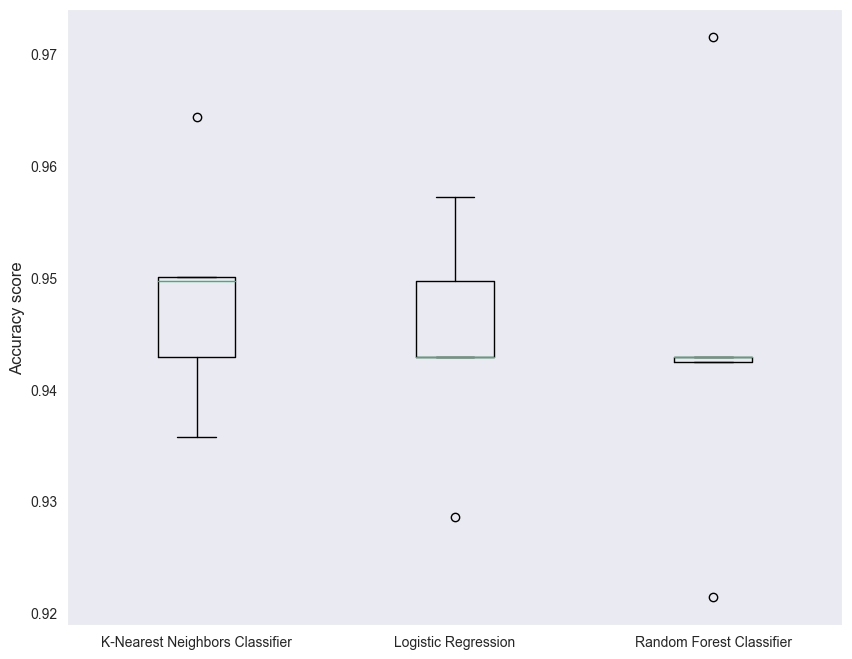

K-Nearest Neighbors Classifier Test Set Accuracy: 0.9428571428571428
Logistic Regression Test Set Accuracy: 0.9542857142857143
Random Forest Classifier Test Set Accuracy: 0.9542857142857143


In [31]:
# Evaluating multiple models
def boxplot_cv_performances_from_pipes() -> None:
    results = []

    for pipeline in pipelines.values():
        kf = KFold(n_splits=5)
        cv_results = cross_val_score(pipeline, x_train, y_train, cv=kf)
        results.append(cv_results)

    # Plot Cross-Validation Performance
    sns.set_style('dark')
    plt.figure(figsize=(10, 8))
    plt.boxplot(results, labels=pipelines.keys(), medianprops={'color': 'mediumseagreen'})
    plt.ylabel('Accuracy score', fontsize=12)

    plt.show()

    # Test set performance
    for name, pipeline in pipelines.items():
        pipeline.fit(x_train, y_train)
        test_score = pipeline.score(x_test, y_test)
        print(f"{name} Test Set Accuracy: {test_score}")


print(
    'Figure 4. Cross-Validation Performance for Three Models:\n KNN, Logistic Regression, and Random Forest Classifier')
boxplot_cv_performances_from_pipes()

As mentioned above, we can use different metrics to evaluate the performance of our model.

Figure 4 represents the distribution of accuracy scores (percentage of correct predictions) obtained by cross-validation, which divides the data set into several folders, using one folder as the validation set and the others as the training set. This process is repeated for each folder and finally, the results are combined, such as by calculating the mean, to obtain an estimate of the model performance. We can visually see what was expressed in table 2 confirming that Logistic regression has the best performance.

Another way is to use the ROC-AUC and PR-AUC curves to measure the ability of a classification model to discriminate between two classes, but they focus on different aspects.

The ROC curve represents the model's ability to discriminate between positive and negative classes. The ROC curve shows the relationship between the True Positive Rate (TPR), which is the percentage of true positives classified correctly to total positives, on the y-axis and the False Positive Rate (FPR), which is the percentage of false positives classified incorrectly to total negatives, on the x-axis. To create the curve, the model's classification threshold, which determines the cut-off point between positive and negative classes, is varied. At each threshold value, the corresponding TPR and FPR value is calculated and a point is drawn on the ROC curve. An ideal ROC curve should get as close as possible to the upper left side of the graph, indicating a high TPR and low FPR. The closer the ROC AUC value is to 1, the better the model's ability to distinguish between the two classes.

On the other hand, the PR curve represents the trade-off between Precision and Recall, highlighting the model's ability to find all positives (Recall) and classify them correctly (Precision), but does not account for negatives. The PR curve is obtained by plotting Precision on the y-axis and Recall on the x-axis. To construct the curve, one starts with the highest recall value 1 and calculates the corresponding precision. Then, you move to the right along the x-axis (i.e., decrease the recall value) and calculate the corresponding precision. You repeat the process until you arrive at the lowest recall value 0. An ideal PR curve should come as close as possible to the upper right side of the graph, indicating high Precision and high Recall.

Figure 5 below demonstrates that although all models performed better than the base rate, the worst-performing model concerning the ROC-AUC and PR-AUC metrics is K-Nearest Neighbors Classifier. Therefore, we decided to perform Hyperparameter tuning Logistic Regression to see if we are able to obtain better performance.

Figure 5. Test set area under the ROC curve and PR curve


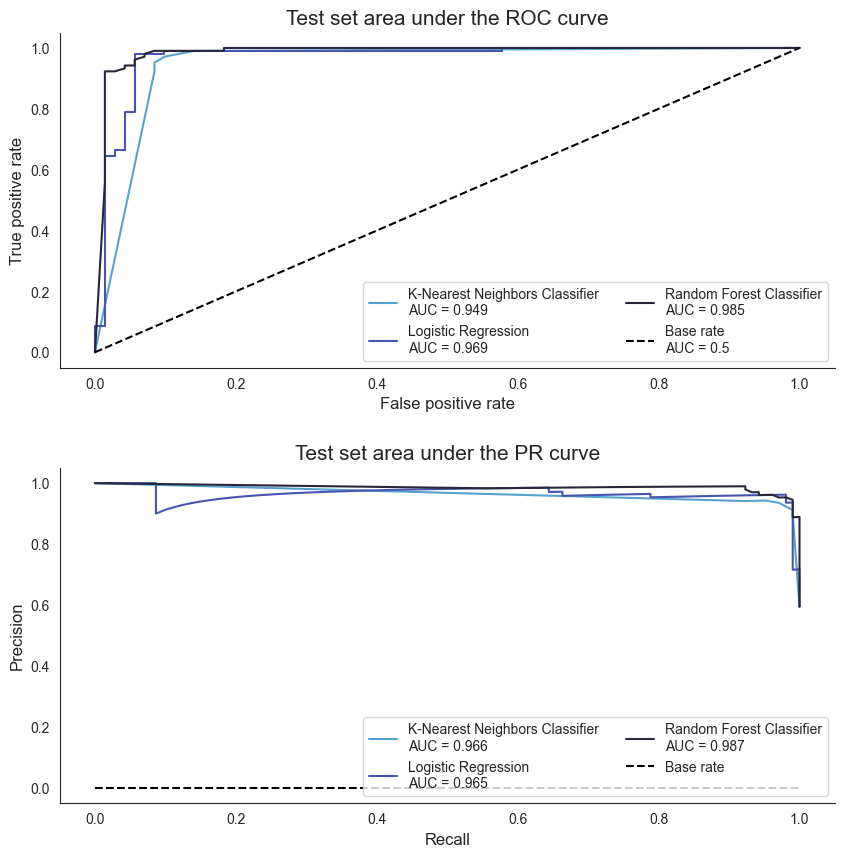

In [32]:
def roc_pr_auc_curves_from_pipes() -> None:
    fprss = []
    tprss = []
    precs = []
    recs = []
    roc_aucs = []
    pr_aucs = []

    for name, pipeline in pipelines.items():
        y_probs = pipeline.predict_proba(x_test)[:, 1]

        fprs, tprs, _ = roc_curve(y_test, y_probs)
        precisions, recalls, _ = precision_recall_curve(y_test, y_probs)

        fprss.append(fprs)
        tprss.append(tprs)
        precs.append(precisions)
        recs.append(recalls)
        roc_aucs.append(roc_auc_score(y_test, y_probs))
        pr_aucs.append(auc(recalls, precisions))

    sns.set_style('white')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    for i in range(len(fprss)):
        model_name = list(pipelines.keys())[i]
        label_model = f"{model_name}\nAUC = {roc_aucs[i]:.3f}"
        ax1.plot(fprss[i], tprss[i], label=label_model)
    ax1.plot([0, 1], [0, 1], linestyle='--', label='Base rate\nAUC = 0.5', color='black')
    ax1.set_xlabel('False positive rate', fontsize=12)
    ax1.set_ylabel('True positive rate', fontsize=12)
    ax1.set_title('Test set area under the ROC curve', fontsize=15)
    ax1.legend(loc="lower right", ncol=2, frameon=True)

    for i in range(len(precs)):
        model_name = list(pipelines.keys())[i]
        label_model = f"{model_name}\nAUC = {pr_aucs[i]:.3f}"
        ax2.plot(recs[i], precs[i], label=label_model)
    ax2.plot([0, 1], [0, 0], linestyle='--', label='Base rate', color='black')
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Test set area under the PR curve', fontsize=15)
    ax2.legend(loc="lower right", ncol=2, frameon=True)
    plt.subplots_adjust(hspace=0.3)
    sns.despine()

    plt.show()


print('Figure 5. Test set area under the ROC curve and PR curve')
roc_pr_auc_curves_from_pipes()

In [33]:
# Hyperparameter tuning Logistic Regression
def hyperparameter_tuning_logistic_regression() -> Tuple[BayesSearchCV, float]:
    np.int = np.int64
    start_time = time.time()
    param_grid = {'logisticregression__solver': ['liblinear', 'saga'],
                  'logisticregression__penalty': ['l1', 'l2'],
                  'logisticregression__tol': (1e-6, 1e-3, 'log-uniform'),
                  'logisticregression__C': (1e-6, 1e-5, 'log-uniform'),
                  'logisticregression__class_weight': [None, 'balanced'],
                  'logisticregression__max_iter': [12000, 15000, 18000]}

    cv = StratifiedKFold(shuffle=True, random_state=seed)

    grid_lr_ = BayesSearchCV(estimator=pipelines['Logistic Regression'],
                             search_spaces=param_grid,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1)

    grid_lr_.fit(x_train, y_train)

    end_time = time.time()
    execution_time_ = (end_time - start_time) / 60

    return grid_lr_, execution_time_


grid_lr, execution_time = hyperparameter_tuning_logistic_regression()
print(f'The best estimator is: {grid_lr.best_estimator_}\n'
      f'The best params are: {grid_lr.best_params_}\n'
      f'The best score is: {grid_lr.best_score_}\n'
      f'Execution time: {execution_time:.3f} minutes')

The best estimator is: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['age', 'systolic',
                                                   'cholesterol',
                                                   'max_heart_rate',
                                                   'ST_depression',
                                                   'number_of_major_vessels']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'angina', 'diabetes',
                                                   'electrocardiogram',
                                                   'exercise_induced_angina',
                                                   'ST_slope',
                       

The final algorithm, optimized through the use of GridSearchCV, was evaluated on the test data (Table 4, Figure 6) and shown to have:
- an accuracy of 90.8%,
- an area under the precision-recall curve (PR_AUC) of 94.7% ,
- an area under the receiver operating characteristic curve (ROC_AUC) of 94.3%.

These results indicate that **the algorithm can distinguish between readmitted and non-readmitted patients with a probability between 94.3% and 94.7%,** depending on the chosen metric.

In addition, the algorithm **correctly classified 99 heart disease patients (true positives) and 60 no heart disease patients (true negatives)** out of a total of 175 patients in the test set. However, the algorithm also made errors, with **5 heart disease patients misclassified as no heart disease (type I errors) and 11 no heart disease patients misclassified as heart disease (type II errors),** as highlighted in Figure 7.

In [34]:
# Getting metrics from tuned model
def metrics_test_from_tuned(model: BayesSearchCV) -> pd.io.formats.style.Styler:
    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_pr_aucs = []
    test_precs = []
    test_recs = []
    test_specs = []
    test_fprs_list = []
    test_fnrs_list = []

    mod = model.best_estimator_
    y_pred_test = mod.predict(x_test)

    y_probs_test = mod.predict_proba(x_test)[:, 1]

    test_precisions, test_recalls, threshold = precision_recall_curve(y_test, y_probs_test)

    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

    test_accs.append(accuracy_score(y_test, y_pred_test))
    test_f1s.append(f1_score(y_test, y_pred_test))
    test_roc_aucs.append(roc_auc_score(y_test, y_probs_test))
    test_pr_aucs.append(auc(test_recalls, test_precisions))
    test_precs.append(precision_score(y_test, y_pred_test))
    test_recs.append(recall_score(y_test, y_pred_test))
    test_specs.append(tn_test / (tn_test + fp_test))
    test_fprs_list.append(fp_test / (fp_test + tn_test))
    test_fnrs_list.append(fn_test / (fn_test + tp_test))

    test_metrics = pd.DataFrame(
        {'model': [model.best_estimator_.steps[-1][1].__class__.__name__],
         'accuracy': test_accs,
         'f1_score': test_f1s,
         'roc_auc': test_roc_aucs,
         'pr_auc': test_pr_aucs,
         'precision': test_precs,
         'recall': test_recs,
         'specificity': test_specs,
         'false_positive_rate': test_fprs_list,
         'false_negative_rate': test_fnrs_list})

    return test_metrics.transpose().reset_index().rename(columns={'index': 'metrics', 0: 'values'}).style \
        .set_properties(**{'font-size': '10pt',
                           'text-align': 'center'}) \
        .set_caption('Table 4: Best estimator metrics table.')


metrics_test_from_tuned(grid_lr)

,metrics,values
0,model,LogisticRegression
1,accuracy,0.908571
2,f1_score,0.925234
3,roc_auc,0.942985
4,pr_auc,0.947412
5,precision,0.900000
6,recall,0.951923
7,specificity,0.845070
8,false_positive_rate,0.154930
9,false_negative_rate,0.048077


Figure 6: Best model ROC and PR curves


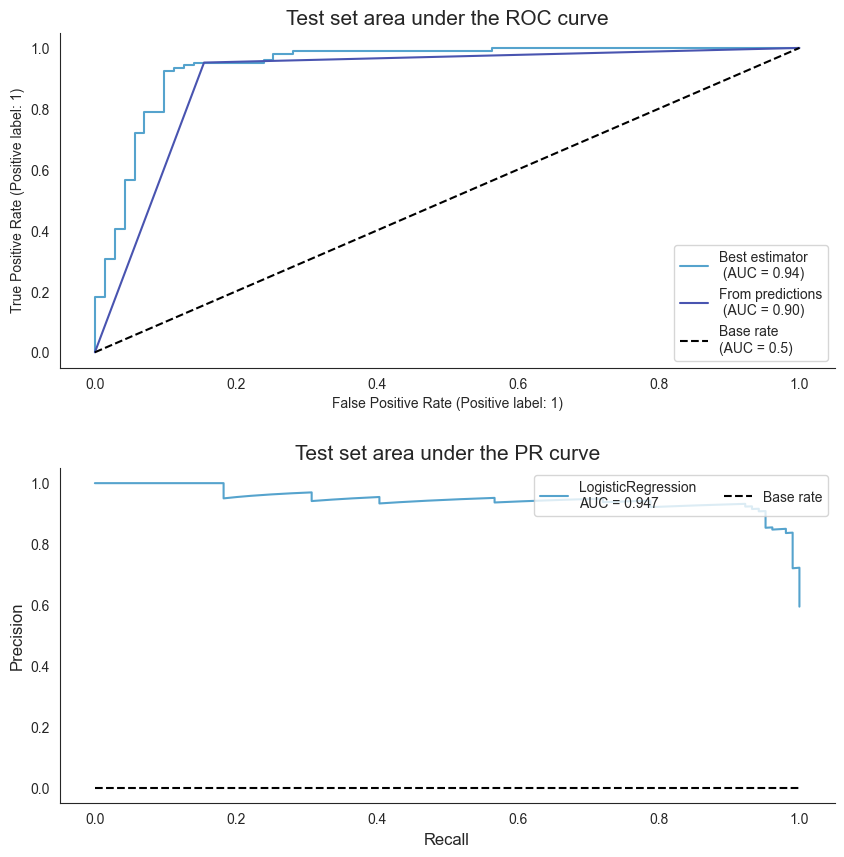

In [35]:
# Plot roc_pr_auc curves from best estimator
def roc_pr_auc_curves_from_best_estimator(model):
    precs = []
    recs = []
    pr_aucs = []

    mod = model.best_estimator_
    y_pred = model.predict(x_test)
    y_probs = mod.predict_proba(x_test)[:, 1]

    precisions, recalls, _ = precision_recall_curve(y_test, y_probs)
    precs.append(precisions)
    recs.append(recalls)
    pr_aucs.append(auc(recalls, precisions))

    sns.set_style('white')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    RocCurveDisplay.from_estimator(mod, x_test, y_test, name='Best estimator\n', ax=ax1)
    RocCurveDisplay.from_predictions(y_test, y_pred, name='From predictions\n', ax=ax1)
    ax1.plot([0, 1], ls="--", color='k', label='Base rate\n(AUC = 0.5)')
    ax1.set_title('Test set area under the ROC curve', fontsize=15)
    ax1.legend(loc='lower right', bbox_to_anchor=(1, 0))
    sns.despine()

    for i in range(len(precs)):
        model_name = model.best_estimator_.steps[-1][1].__class__.__name__
        label_model = f"{model_name}\nAUC = {pr_aucs[i]:.3f}"
        ax2.plot(recs[i], precs[i], label=label_model)
    ax2.plot([0, 1], [0, 0], linestyle='--', label='Base rate', color='black')
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Test set area under the PR curve', fontsize=15)
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 1), ncol=2, frameon=True)
    plt.subplots_adjust(hspace=0.3)
    sns.despine()


print('Figure 6: Best model ROC and PR curves')
roc_pr_auc_curves_from_best_estimator(grid_lr)

**Note:** The difference between the two AUC (Area Under the Curve) might indicate that the better model performs slightly better on the test set than its predictions alone (y_pred). However, the 4% difference between the two AUCs is not very large and may not be statistically significant.

Figure 7: Best estimator confusion matrix.


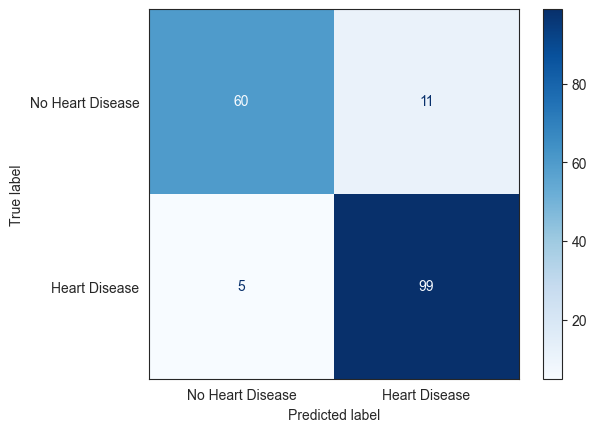

In [36]:
# Plot confusion matrix from best estimator
def plot_confusion_matrix_from_best_estimator(model):
    y_pred = model.predict(x_test)

    cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                                display_labels=['No Heart Disease', 'Heart Disease'])

    print('Figure 7: Best estimator confusion matrix.')
    cm.plot(cmap='Blues')
    plt.show()


plot_confusion_matrix_from_best_estimator(grid_lr)

Figure 8 displays which feature affects the performance of the machine learning model, indicating how much a feature contributes to the model's ability to make accurate predictions.

Evaluating feature performances is important because it can help identify which features are most important for prediction and which can be eliminated or modified to improve model performance. In addition, understanding feature performances can help to better understand the nature of the classification problem and identify the variables that are most significant for prediction.

Figure 8: BayesSearchCV best estimator (Logistic Regression) important coefficient.


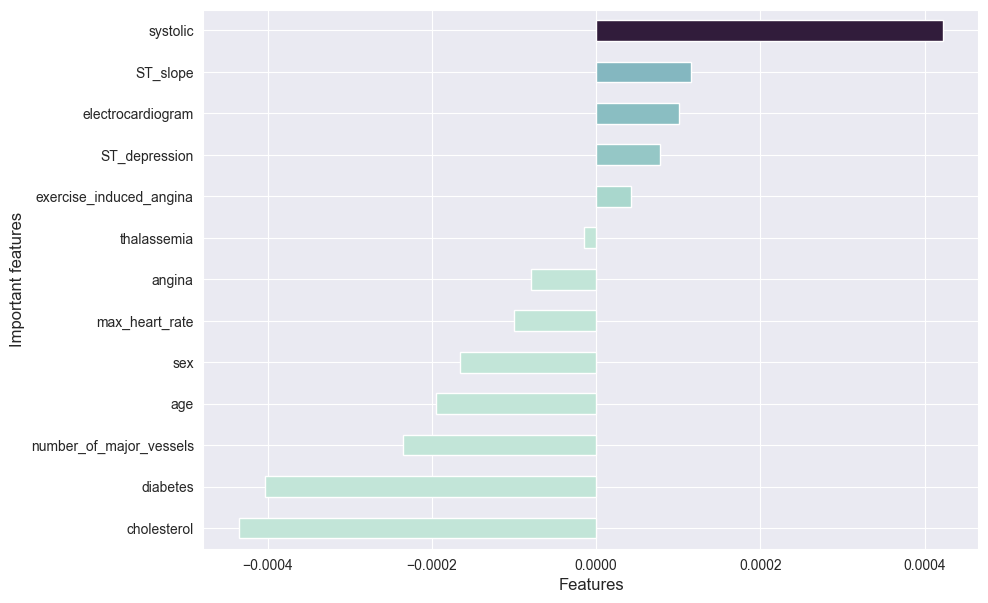

In [37]:
# Plot important features from best estimator
def plot_important_features_from_best_estimator(model):
    coefficients = model.best_estimator_.named_steps.logisticregression.coef_[0]
    important_model = pd.Series(coefficients[:len(x.columns)],
                                index=x
                                .columns[:len(coefficients[:len(x.columns)])]).sort_values()

    sns.set_style('darkgrid')
    plt.subplots(figsize=(10, 7))
    palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

    important_model.plot(kind='barh', color=palette(important_model / float(important_model.max())))
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Important features', fontsize=12)

    plt.show()


print('Figure 8: BayesSearchCV best estimator (Logistic Regression) important coefficient.')
plot_important_features_from_best_estimator(grid_lr)

We can conclude that the features that most affect our model are:
- **systolic**
- **ST_slope**
- **electrocardiogram**